# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


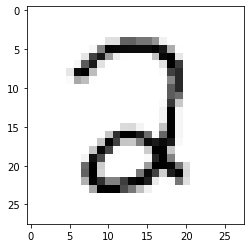

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2464
Training Accuracy: 0.6562, Testing Accuracy: 0.6658



Epoch 10, Loss 0.1037
Training Accuracy: 0.9199, Testing Accuracy: 0.9284



Epoch 20, Loss 0.0599
Training Accuracy: 0.9427, Testing Accuracy: 0.9516



Epoch 30, Loss 0.0457
Training Accuracy: 0.9517, Testing Accuracy: 0.9642



Epoch 40, Loss 0.0391
Training Accuracy: 0.9570, Testing Accuracy: 0.9677



Epoch 50, Loss 0.0353
Training Accuracy: 0.9600, Testing Accuracy: 0.9693



Epoch 60, Loss 0.0327
Training Accuracy: 0.9615, Testing Accuracy: 0.9693



Epoch 70, Loss 0.0307
Training Accuracy: 0.9637, Testing Accuracy: 0.9708



Epoch 80, Loss 0.0292
Training Accuracy: 0.9652, Testing Accuracy: 0.9718



Epoch 90, Loss 0.0278
Training Accuracy: 0.9670, Testing Accuracy: 0.9723



Epoch 100, Loss 0.0267
Training Accuracy: 0.9684, Testing Accuracy: 0.9728



Epoch 110, Loss 0.0257
Training Accuracy: 0.9702, Testing Accuracy: 0.9743



Epoch 120, Loss 0.0248
Training Accuracy: 0.9715, Testing Accuracy: 0.9748



Epoch 130, Loss 0.024
Training Accuracy: 0.9720, Testing Accuracy: 0.9753



Epoch 140, Loss 0.0233
Training Accuracy: 0.9730, Testing Accuracy: 0.9753



Epoch 150, Loss 0.0226
Training Accuracy: 0.9743, Testing Accuracy: 0.9748



Epoch 160, Loss 0.0219
Training Accuracy: 0.9750, Testing Accuracy: 0.9763



Epoch 170, Loss 0.0213
Training Accuracy: 0.9755, Testing Accuracy: 0.9768



Epoch 180, Loss 0.0207
Training Accuracy: 0.9762, Testing Accuracy: 0.9773



Epoch 190, Loss 0.0202
Training Accuracy: 0.9777, Testing Accuracy: 0.9773



Epoch 200, Loss 0.0197
Training Accuracy: 0.9786, Testing Accuracy: 0.9768



Epoch 210, Loss 0.0192
Training Accuracy: 0.9790, Testing Accuracy: 0.9763



Epoch 220, Loss 0.0187
Training Accuracy: 0.9796, Testing Accuracy: 0.9763



Epoch 230, Loss 0.0182
Training Accuracy: 0.9803, Testing Accuracy: 0.9768



Epoch 240, Loss 0.0178
Training Accuracy: 0.9810, Testing Accuracy: 0.9768



0.023231999075955953

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2619
Training Accuracy: 0.6162, Testing Accuracy: 0.6174



Epoch 10, Loss 0.1067
Training Accuracy: 0.9027, Testing Accuracy: 0.9128



Epoch 20, Loss 0.0814
Training Accuracy: 0.9251, Testing Accuracy: 0.9360



Epoch 30, Loss 0.0697
Training Accuracy: 0.9337, Testing Accuracy: 0.9441



Epoch 40, Loss 0.0628
Training Accuracy: 0.9394, Testing Accuracy: 0.9491



Epoch 50, Loss 0.058
Training Accuracy: 0.9443, Testing Accuracy: 0.9516



Epoch 60, Loss 0.0545
Training Accuracy: 0.9468, Testing Accuracy: 0.9546



Epoch 70, Loss 0.0519
Training Accuracy: 0.9487, Testing Accuracy: 0.9561



Epoch 80, Loss 0.0497
Training Accuracy: 0.9511, Testing Accuracy: 0.9572



Epoch 90, Loss 0.048
Training Accuracy: 0.9518, Testing Accuracy: 0.9577



Epoch 100, Loss 0.0465
Training Accuracy: 0.9528, Testing Accuracy: 0.9587



Epoch 110, Loss 0.0452
Training Accuracy: 0.9543, Testing Accuracy: 0.9587



Epoch 120, Loss 0.0441
Training Accuracy: 0.9548, Testing Accuracy: 0.9602



Epoch 130, Loss 0.0432
Training Accuracy: 0.9556, Testing Accuracy: 0.9612



Epoch 140, Loss 0.0423
Training Accuracy: 0.9564, Testing Accuracy: 0.9617



Epoch 150, Loss 0.0415
Training Accuracy: 0.9569, Testing Accuracy: 0.9617



Epoch 160, Loss 0.0409
Training Accuracy: 0.9578, Testing Accuracy: 0.9627



Epoch 170, Loss 0.0402
Training Accuracy: 0.9585, Testing Accuracy: 0.9632



Epoch 180, Loss 0.0396
Training Accuracy: 0.9590, Testing Accuracy: 0.9642



Epoch 190, Loss 0.0391
Training Accuracy: 0.9592, Testing Accuracy: 0.9642



Epoch 200, Loss 0.0386
Training Accuracy: 0.9597, Testing Accuracy: 0.9647



Epoch 210, Loss 0.0382
Training Accuracy: 0.9597, Testing Accuracy: 0.9647



Epoch 220, Loss 0.0378
Training Accuracy: 0.9602, Testing Accuracy: 0.9652



Epoch 230, Loss 0.0374
Training Accuracy: 0.9605, Testing Accuracy: 0.9652



Epoch 240, Loss 0.037
Training Accuracy: 0.9608, Testing Accuracy: 0.9657



0.048827821877424724

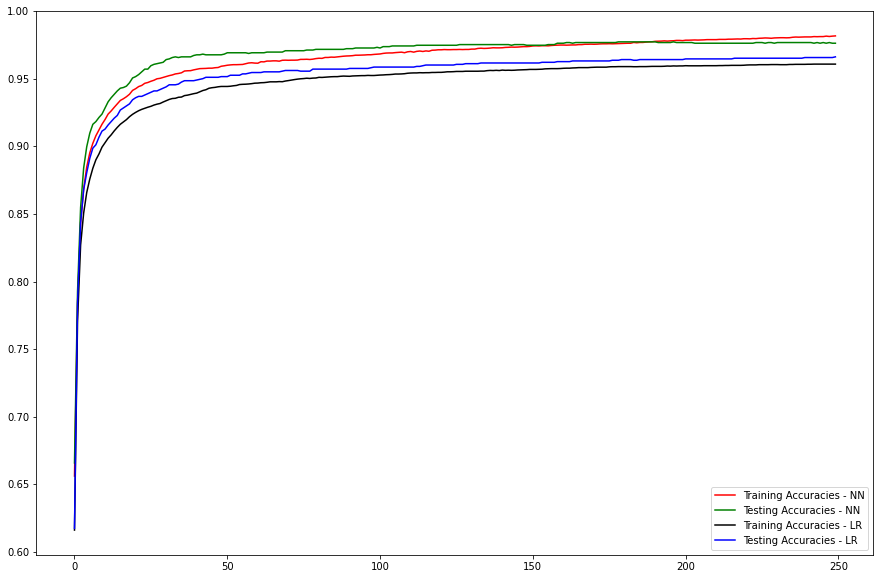

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

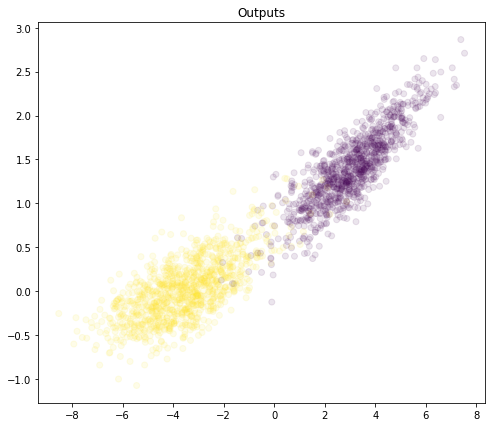

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

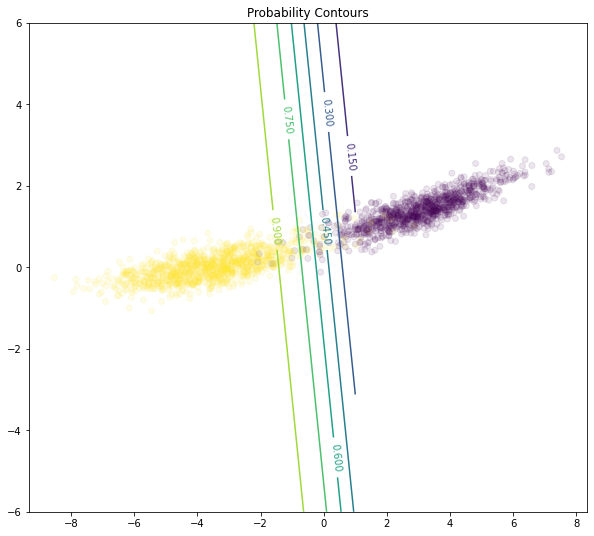

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );